In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_class_path, HELMConverter
from node import MolSentenceNode #TODO: change after Filter implementation <- ?
from generator import MCTS

c:\Users\fsfsf\anaconda3\envs\molgen-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_path, model_dir, lang_class_path, lang_path = (conf.get(k) for k in ("model_class_path", "model_dir", "lang_class_path", "lang_path"))
lang_class = get_class_from_class_path(lang_class_path)
lang = lang_class.load(repo_root + lang_path)
if lang_class_path.endswith("HELM"): #TODO: should be removed after .lang inclusion
    lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_class_path(model_class_path)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_path, reward_conf = (conf.get(k) for k in ("reward_class_path", "reward_conf"))
reward_class = get_class_from_class_path(reward_class_path)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_path", "policy_conf"))
policy_class = get_class_from_class_path(policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_class_path(s.get("filter_class_path"))
    filters.append(filter_class(**s.get("filter_conf", {})))

Search is started.
0- time: 0.19, count_rollouts: 1, reward: -0.7553094297794659, node: PEPTIDE1{Q.R.F.C.T.G.H.F.G.G.L.Y.Q.A.G.G.Q}$$$$
1- time: 0.35, count_rollouts: 2, reward: -0.03732565141017854, node: PEPTIDE1{[ac].H.F.R.W.[am]}$$$$
2- time: 0.42, count_rollouts: 3, reward: -0.11013147196553529, node: PEPTIDE1{[ac].S.N.W.K.W.W.P.G.I.F.D.[am]}$$$$
3- time: 0.48, count_rollouts: 4, reward: -0.445092027224316, node: PEPTIDE1{R.G.D.S}$$$$
4- time: 0.52, count_rollouts: 5, reward: -0.266367675168792, node: PEPTIDE1{Y.V.[dP].T.N.V.G.F.E.A.F}$$$$
5- time: 0.75, count_rollouts: 7, reward: -0.8026780526655841, node: PEPTIDE1{F.G.G.F.T.G.A.R.K.S.A.R.K.L.A.N.Q}$$$$
6- time: 0.83, count_rollouts: 8, reward: -0.0929707361990665, node: PEPTIDE1{A.I.A.[dK]}$$$$
7- time: 0.88, count_rollouts: 9, reward: -0.7049911894345944, node: PEPTIDE1{T.P.R.E.R.R.R.K.K.R.V}$$$$
8- time: 0.94, count_rollouts: 10, reward: -0.6816983590156551, node: PEPTIDE1{K.A.P.A.S.A.G.E.E.V.N.H.[am]}$$$$
9- time: 1.00, count

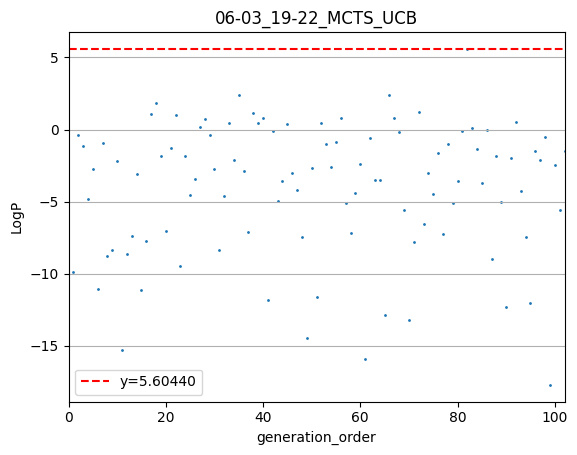

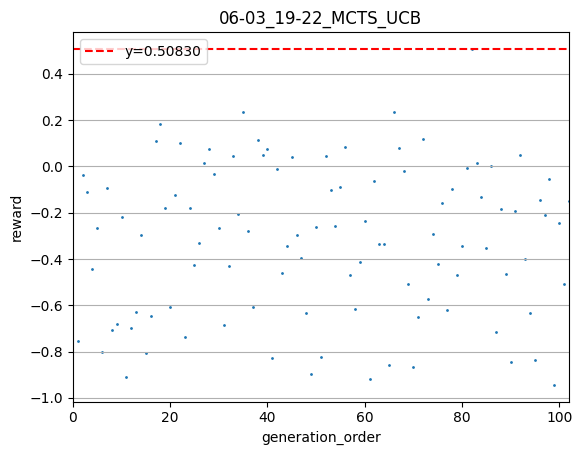

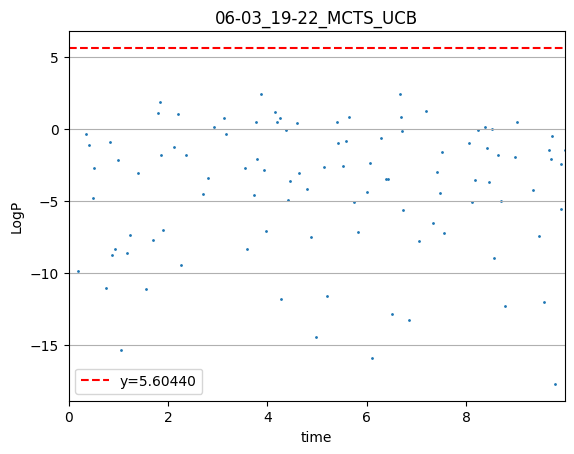

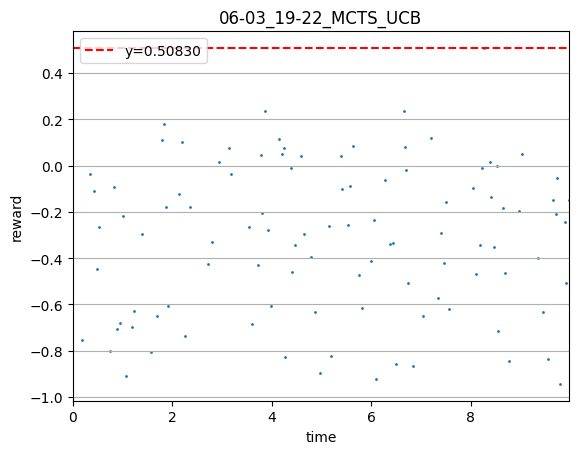

Search is completed.


In [4]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang)

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)